<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/MNIST_Val_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-f_gg_40e/base-rbt_20203d62e31047a9978dab5535a42e6a
  Running command git clone -q https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-f_gg_40e/base-rbt_20203d62e31047a9978dab5535a42e6a
     |████████████████████████████████| 551 kB 29.9 MB/s 
     |████████████████████████████████| 41 kB 249 kB/s 
     |████████████████████████████████| 549 kB 69.1 MB/s 
     |████████████████████████████████| 182 kB 82.9 MB/s 
  Created wheel for base-rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=20565 sha256=dfbc295dc92f4087f3ebc20dd4ecaaf7277f4fff108ef1f18b6ef61503b7ff05
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9_wnkqs/wheels/b3/25/be/8368facea57a956938db327bdd708e7f93ca5738de036e2c6e
Successfully built base-rbt


In [53]:
from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

In [54]:
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

Step 1): We need the data, and to set all the hps. 

In [55]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
seed=20 #Will have to try with different random seeds. Two times is probably enough 
n_in=1
indim=1024 #find this by inspection, e.g. for resnet18 is 1024
size=28
ps=500 #Will also try with other values e.g. 125, 1000 etc
bs=128 #for training BT
bs_val=20 #for training linear head
bs_test=500
ts_val=bs_val*4 #so 512, ~ 1% of 50000
ts=10000

n_epochs=300 #epochs for BT 
numfit = 200 #epochs for linear classifer

In [56]:
#Let's get MNIST data in a nicer way

path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort()
seed_everything(seed=seed)
items=items.shuffle()
label_func=RegexLabeller(pat = r'/training/(\d)/')
labels = [label_func(i) for i in items]

items_train = items[0:ts] #train on ts samples
labels_train = labels[0:ts]
dls_train = ImageDataLoaders.from_lists(path,items_train, labels_train,bs=bs,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,item_tfms=[ToTensor()],
                                  img_cls=PILImageBW)

items_tune = items[ts:ts+3000]
labels_tune = labels[ts:ts+3000]

items_test = items[ts+3000:ts+3000+ts] #test on ts samples. 3k held out for tuning
labels_test = labels[ts+3000:ts+3000+ts]
dls_test = ImageDataLoaders.from_lists(path,items_test, labels_test,bs=bs_test,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,
                                  img_cls=PILImageBW
                                      )
def tune_set(items0,seed=42):

    seed_everything(seed=seed)
    items=items0.shuffle()
    raw=[]
    items_tune20 = []
    labels_tune20 = []

    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}

    for i in items:
    
        label = label_func(i)
        if d[label] == 0 or d[label] == 1:
            items_tune20.append(i)
            labels_tune20.append(label)
            d[label] += 1
            raw.append(i)

    dls_val = ImageDataLoaders.from_lists(path, items_tune20, labels_tune20,bs=20,
                                  valid_pct=0.0,num_workers=2*(device=='cuda'),device=device,
                                      img_cls=PILImageBW)

    d = {'items_tune20':items_tune20,'labels_tune20':labels_tune20,'raw':raw,'dls_val':dls_val}
    
    return d


In [ ]:
#Test dls_train, dls_val, dls_test and that function `tune_set` is working 

test_eq(seed,42)
test_eq(ts,10000)

x,y = dls_train.one_batch()
test_eq(x.shape, [bs, 1, 28, 28])

test_eq(len(dls_train.train_ds),ts)
test_eq(len(dls_test.train_ds),ts)

test_eq(len(dls_test.train)*bs_test,len(dls_test.train_ds))

_tune_set = tune_set(items_tune,seed=seed+1)
items_tune20,labels_tune20,dls_val,raw = _tune_set['items_tune20'],_tune_set['labels_tune20'], _tune_set['dls_val'],_tune_set['raw']


my_dict = {i:labels_tune20.count(i) for i in labels_tune20}
for i in my_dict.values():
    test_eq(i,2)

#test size
test_eq(len(dls_val.train),1)
test_eq(len(dls_val.train_ds),20)

#test random seed (please note that this depends on random seed chosen above to sort initially, i.e. seed=42)
_raw = tune_set(items_tune,seed=1)['raw']
test_eq(_raw[0].name,'28316.png')

_raw = tune_set(items_tune,seed=10)['raw']
test_eq(_raw[11].name,'11658.png')


AssertionError: ignored

Test the random seed:

Patch in definition of loss function (BT for now):

In [68]:
#Eventually have to edit elsewhere i.e. in package (once stable)

def C_z1z2(z1norm,z1norm_2,z2norm,z2norm_2,indep=True):

    bs = z1norm.shape[0]
    if indep == False:
        C1 =  (z1norm.T @ z2norm_2) / bs
        C2 = (z1norm_2.T @ z2norm) / bs
        cdiff = (0.5*C1.pow(2) + 0.5*C2.pow(2))
        
    elif indep == True:
        C =  (z1norm_2.T @ z2norm_2) / bs
        cdiff = C.pow(2)
    
    return cdiff

class Max_Corr(nn.Module):
    def __init__(self,qs,act1='relu',act2='sigmoid'):
        super().__init__()
        self.qs=qs
        
        self.fc1 = nn.Linear(qs,qs)
        self.fc11 = nn.Linear(qs,qs)
        self.fc2 = nn.Linear(qs,qs)
        self.fc22 = nn.Linear(qs,qs)

        if act1=='relu': self.act1=nn.ReLU() 
        elif act1 == 'sigmoid': self.act1 = nn.Sigmoid()

        if act2=='relu': self.act2=nn.ReLU() 
        elif act2 == 'sigmoid': self.act2 = nn.Sigmoid()
        
        self.m1 = nn.Sequential(self.fc1,self.act1,self.fc11)
        self.m2 = nn.Sequential(self.fc2,self.act2,self.fc22)


    def forward(self,x,y):
        return self.m1(x),self.m2(y)
        
#| export
class Cdiff_Sup:
    
    def __init__(self,I,qs,inner_steps,indep=True,act1='relu',act2='sigmoid',mask=True):
        
        self.I=I
        self.qs=qs
        self.inner_steps=inner_steps
        self.indep=indep

        self.act1=act1
        self.act2=act2

        self.max_corr = Max_Corr(qs=qs,act1=self.act1,act2=self.act2)
        if default_device().type == 'cuda':
            self.max_corr.cuda()
        
    def inner_step(self,z1norm,z2norm):
    
        max_corr=self.max_corr
        inner_steps=self.inner_steps
        z1norm=z1norm.detach()
        z2norm=z2norm.detach()
        optimizer = torch.optim.Adam(list(max_corr.parameters()),lr=0.001)
        #optimizer = torch.optim.SGD(list(max_corr.parameters()),lr=0.01)
        
        for i in range(inner_steps):

            z1norm_2,z2norm_2=max_corr(z1norm,z2norm)
            cdiff_2 = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,indep=self.indep)
            inner_loss=-1*(cdiff_2*(1-self.I)).mean()
            optimizer.zero_grad()
            inner_loss.backward()
            optimizer.step()
        
        for p in max_corr.parameters():
            p.requires_grad=False
            
        return max_corr
    
    def __call__(self,z1norm,z2norm):
        
            max_corr =  self.inner_step(z1norm,z2norm)
            z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
            cdiff_sup = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,indep=self.indep)


            
            return cdiff_sup

In [69]:
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


HP = AttributeDict(t=0.5, #convexity level
               indep_rand=True,indep_sup=False,enc_rand=False,enc_sup=True, 
               inner_steps=15,act1='relu',act2='sigmoid', #belong to sup term
               K=10,phase_std=0.2,amp_std=0.2,off_std=1)


def lf_rbt_enc(pred,I,lmb,
               hp,
               ):

    pred_enc = pred[0]
    pred = pred[1]
    
    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    
    z1_enc, z2_enc = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_enc = (z1_enc - z1_enc.mean(0)) / z1_enc.std(0, unbiased=False)
    z2norm_enc = (z2_enc - z2_enc.mean(0)) / z2_enc.std(0, unbiased=False)


    if hp.enc_sup:
        z1norm_sup = z1norm_enc
        z2norm_sup = z2norm_enc

    else:
        z1norm_sup = z1norm
        z2norm_sup = z2norm


    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2

    # C_enc = (z1norm_enc.T @ z2norm_enc) / bs
    # cdiff_enc = (C - I)**2

    # #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
    # #where the max is over f and g. Please see base_lf for details
    CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=hp.inner_steps,indep=hp.indep_sup)
    cdiff_sup = CdiffSup(z1norm_sup,z2norm_sup) #same shape as cdiff

    #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
    # CdiffRand = Cdiff_Rand(phase_std=hp.phase_std,amp_std=hp.amp_std,off_std=hp.off_std,
    #                       K=hp.K,indep=hp.indep_rand
    #                       )
    # cdiff_rand = CdiffRand(z1norm_rand,z2norm_rand) #same shape as cdiff
    

    #cdiff_2 = hp.t*cdiff_2_2 + (1-hp.t)*cdiff_2 #convex combination of rand and sup terms.
    
    #cdiff_2 = hp.t*cdiff_rand + (1-hp.t)*cdiff_sup #i.e. rand term + bt term (no sup term)
    
    #rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)
    
    #uncomment
    rr=hp.t*(cdiff_sup*(1-I)).sum()
    loss = (cdiff*I).sum() + rr #sum of redundancy reduction term and invariance term
    
    #loss = (cdiff*I).sum() + lmb*(cdiff*(1-I)).sum()
    
    torch.cuda.empty_cache()
    return loss

In [70]:
# #Using RBT_enc
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_rbt_enc(pred,I=self.I,lmb=self.lmb,hp=HP)

We also patch `before_epoch` so that we are training linear classifier:
    

Setup for linear evaluation:

In [71]:
aug_pipelines_val=[get_linear_batch_augs(size=28,stats=mnist_stats,resize=True,resize_scale=(0.4, 1.0))]

# main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
#                     dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
#                     stats=mnist_stats,
#                     aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
#                     encoder=None#encoder
#                                 )

Optional: Show linear augmentations:

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.1310]]]], device='cuda:0'), 'std': tensor([[[[0.3080]]]], device='cuda:0'), 'axes': (0, 2, 3)}

Pipeline: 


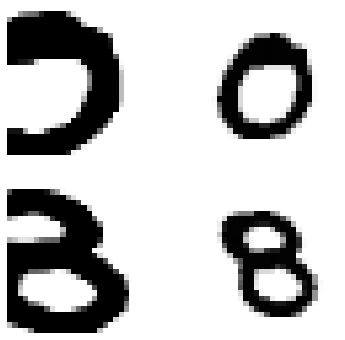

In [ ]:
show_linear_batch(dls=dls_val,n_in=n_in,n=2,aug=aug_pipelines_val,print_augs=True)

Patch linear evaluation into `after_epoch:`

Define encoder and model; Define augmentation pipelines; Define learner.  

In [72]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)

#If we are using a different model, this call will just look like `create_rat_model(...)`
model = create_p3barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)

aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2),
                    rotate=True,jitter=False,noise=True,bw=False,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2),
                    rotate=True,jitter=False,noise=True,bw=False,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))


#aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)

# noise=True,rotate=True,jitter=True,bw=True,blur=True,solar=True, #Whether to use  given aug or not
# resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.025, rotate_deg=30,jitter_s=.6,blur_s=(4,32),s1=None,sol_t=0.05,sol_a=0.05, #hps of diff augs
# flip_p=0.5, rotate_p=0.3,noise_p=0.2, jitter_p=0.3, bw_p=0.3, blur_p=0.3,sol_p=0.1, #prob of performing aug
# same_on_batch=False,stats=imagenet_stats,cuda=default_device().type == 'cuda',xtra_tfms=[])

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

#If we are using a different `callback` to `BarlowTwins` then we can simply replace `BarlowTwins` with 
#e.g. `BarlowTriplets`. We can define in base_model and just import with no issues. 
learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
#Set path of learn correctly
#learn.path = Path('/content/drive/MyDrive/')

Step 3): (Optional): View the augmentations:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 's1': None, 'blur_r': (0.5, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]], device='cuda:0'), 'std': tensor([[[[0.3080]]]], device='cuda:0'), 'axes': (0, 2, 3)}

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.5, 's': 11, 's1': None, 'blur_r': (0.5, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.1310]]]], device='cuda:0'), 'std': tensor([[[[0.3080]]]], device='cuda:0'), 'axes': (0, 2, 3)}


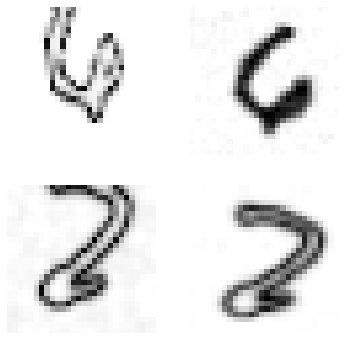

In [ ]:
show_bt_batch(dls=dls_train,n_in=n_in,aug=aug_pipelines,n=2,print_augs=True)

Step 4): Fit the learner:

All we have changed from "best so far" on current run is have _enc on both terms (sup and rand)
instead of just on the _proj term

In [73]:
def sample_hp():
    "Sample hps for training bt -- need number of inner_steps and a bunch of other stuff"


    t = random.uniform(0.04,0.09)

    return AttributeDict({'t':0.07,
    'inner_steps':0,
   'indep_sup': False,
   'enc_sup': True})

    

         

In [74]:
def train_rbt(hp):
        
    @patch
    def lf(self:BarlowTwins, pred,*yb): return lf_rbt_enc(pred,I=self.I,lmb=self.lmb,hp=hp) #pass them to loss function
  
    #train
    fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)
    model = create_p3barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)
    learn = Learner(dls_train,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
    learn.fit(100)

    return fastai_encoder


In [75]:
#Tune run for given hps

def tune_valid(fastai_encoder):
    fastai_encoder.eval() #eval mode
    fastai_encoder = grad_on(fastai_encoder,on=False) #turn off gradients
    acc_dict={}
    for i in range(5):
        dls_val = tune_set(items_tune,seed=seed+i)['dls_val']

        main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                                dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                                stats=mnist_stats,
                                aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                                encoder=fastai_encoder #encoder
                                            )
        #main_linear_eval.encoder = self.encoder (usage within BT training)
        acc=main_linear_eval()
        acc_dict[i]=acc
        
    acc_dict['mean'] = (sum(list(acc_dict.values()))/len(acc_dict.values()))
    print((sum(list(acc_dict.values()))/len(acc_dict.values())))
    
    return acc_dict

In [ ]:
result={} #store the hp dict in here and the acc_dict results for the given hp
for i in range(1):
    hp = sample_hp() #sample hps
    fastai_encoder = train_rbt(hp) #train encoder
    acc_dict = tune_valid(fastai_encoder) #train head and evaluate
    result[i] = {'hp':hp,'acc_dict':acc_dict} #so we are looking for the hp that has highest mean value for acc_dict
    print(result[i]['acc_dict'])
    print(result[i]['acc_dict']['mean'])
    print(result[i]['hp'])
    print('\n')

epoch,train_loss,valid_loss,time
0,93.069565,None,00:08
1,71.407890,None,00:08
2,57.403870,None,00:08
3,48.169811,None,00:08
4,43.275921,None,00:08
5,38.631821,None,00:08
6,33.782902,None,00:08
7,32.370075,None,00:08
8,31.195120,None,00:08
9,29.633930,None,00:08


epoch,train_loss,valid_loss,time
0,2.439736,None,00:01
1,2.269151,None,00:01
2,2.115528,None,00:01
3,1.965528,None,00:01
4,1.815048,None,00:01
5,1.675327,None,00:01
6,1.550719,None,00:01
7,1.435050,None,00:01
8,1.325672,None,00:01
9,1.229534,None,00:01


epoch,train_loss,valid_loss,time
0,2.226614,None,00:01
1,2.057629,None,00:01
2,1.897593,None,00:01
3,1.759748,None,00:01
4,1.661021,None,00:01
5,1.526161,None,00:01
6,1.402070,None,00:01
7,1.295122,None,00:01
8,1.200699,None,00:01
9,1.117049,None,00:01


epoch,train_loss,valid_loss,time
0,2.218570,None,00:01
1,2.064795,None,00:01
2,1.924268,None,00:01
3,1.791836,None,00:01
4,1.666554,None,00:01
5,1.563125,None,00:01
6,1.457426,None,00:01
7,1.352663,None,00:01
8,1.256323,None,00:01
9,1.168385,None,00:01


epoch,train_loss,valid_loss,time
0,2.402591,None,00:01
1,2.228695,None,00:01
2,2.079774,None,00:01
3,1.923801,None,00:01
4,1.781026,None,00:01
5,1.647757,None,00:01
6,1.527677,None,00:01
7,1.417215,None,00:01
8,1.316255,None,00:01
9,1.226244,None,00:01


epoch,train_loss,valid_loss,time
0,2.309751,None,00:01
1,2.172357,None,00:01
2,2.012460,None,00:01
3,1.864524,None,00:01
4,1.747816,None,00:01
5,1.619707,None,00:01
6,1.503141,None,00:01
7,1.410365,None,00:01
8,1.308520,None,00:01
9,1.218343,None,00:01


In [ ]:
#Baseline (ONCE AND FOR ALL!!!) 
BT= {0: 0.8626999855041504, 1: 0.809499979019165, 2: 0.8776000142097473, 3: 0.8116000294685364, 4: 0.8769000172615051, 'mean': 0.8476600050926208}